In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp search

In [ ]:
#| export
import sys
sys.path.insert(0,'..')
from mytools.tools import *
from food.paths import *
from food.psql import *
import requests
import torch
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance,ImageOps
from food.paths import *
# from stego.segment import get_food_segment
from segmentor.segment import *

from mytools.visual import *
from food.depth import *

from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import cv2
import numpy as np
from matplotlib import pyplot as plt

prod


/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/transformers/models/glpn/feature_extraction_glpn.py:28: FutureWarning: The class GLPNFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use GLPNImageProcessor instead.
  warnings.warn(


In [ ]:
#| export
def apply_custom_colormap(image_gray, cmap):

    assert image_gray.dtype == np.uint8, 'must be np.uint8 image'

    # Initialize the matplotlib color map
    sm = plt.cm.ScalarMappable(cmap=cmap)

    # Obtain linear color range
    color_range = sm.to_rgba(np.linspace(0, 1, 256))[:,0:3]    # color range RGBA => RGB
    color_range = (color_range*255.0).astype(np.uint8)         # [0,1] => [0,255]
    # color_range = np.squeeze(np.dstack([color_range[:,2], color_range[:,1], color_range[:,0]]), 0)  # RGB => BGR

    # Apply colormap for each channel individually
    channels = [cv2.LUT(image_gray, color_range[:,i]) for i in range(3)]
    return np.dstack(channels)

In [ ]:
#| export
def get_heatmap(arr,
                colors = ["white","lime","green","yellow","orange", "red","purple","purple","purple","purple","purple","purple"],
                values = [0,           1,     50,     100,     200,   300,     400,     500,     600,     700,     800,     900]):
    
    l = list(zip([v/max(values) for v in values],colors))
    cmap=LinearSegmentedColormap.from_list('hmap',l)
    return apply_custom_colormap((np.array(arr)/max(values)*255).astype(np.uint8),cmap)
    

In [ ]:
#| export
def blend_array2img(img,arr,alphas = [0.5,0.5]):
    return cv2.addWeighted(arr, alphas[0], np.array(img).astype(np.uint8), alphas[1], 0)

In [ ]:
#| export
bad_cats  = ['Vegetables on a sandwich','Candy containing chocolate','Baby juice']
bad_descs = ['Banana, fried']
bad_keys = ['baby food','frozen','juice','drink']
bad_keys_cat = ['formula']

q = """select p.clip, p.text, p.version,f.description,f.category, f.id,f.energy,f.protein,f.carb,f.fat
       from food.foods_prompted as p
       join food.foods as f on (p.food_id = f.id)
       where p.clip is not null
       """


foods = pd.read_sql(q,engine)

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()

foods = foods[~foods['category'].isin(bad_cats)]
foods = foods[~foods['description'].isin(bad_descs)]
foods = foods[~foods['description'].str.contains('|'.join(bad_keys))]
foods = foods[~foods['category']   .str.lower().str.contains('|'.join(bad_keys_cat))]

food_clips = series2tensor(foods['clip'])

In [ ]:
domain = 'https://dima.skynet.center'

In [ ]:
#| export
def search(segment_model,path=None, prompt_factor=0.5,min_score=0.22,exand_times =2):
    img = get_image(path=path)
    img,adj = crop_image_to_square(img,True)
    x_adj,y_adj,size = adj

    photo_id = path.name.split('/')[-1]

    i = np.asarray(img, dtype="uint8")
    i = np.flip(i,2)
    segmentor_mask = inference_segmentor(segment_model, i)[0]
    segmentor_mask[segmentor_mask!=0]=segmentor_mask[segmentor_mask!=0]+1 
    classes = np.unique(segmentor_mask)[1:]
    classes_ =[]

    paths = []
    for c in classes:
        area = segmentor_mask[segmentor_mask==c].shape[0]
        if area> 20*20:
            class_mask = np.where(segmentor_mask==c,1,0)
            class_mask = expand_boundaries(class_mask,times=exand_times,factor=10)
            img_arr = apply_mask(img,class_mask.T).astype(np.uint8)
            img_arr = crop_zeros(img_arr)
            img_arr[img_arr==[0,0,0]]=255 #replace black with while
            fname = f'{photo_id}_{c}.jpg'
            p = fragment_reference_images_path/fname
            paths.append(p)
            Image.fromarray(img_arr).save(p)
            classes_.append(c)
    classes = classes_
    
    if prompt_factor >0: paths = [path]+paths

    clips =torch.Tensor(get_image_clip_from_paths(paths))

    if prompt_factor>0:
        prompt_clip = clips[0]
        clips = clips[1:]
        diff = prompt_clip - clips
        clips = clips + diff*prompt_factor

    dfs = []

    for clip in clips:
        df = foods.copy()
        df['score'] = cos(food_clips,clip)
        dfs.append(df.sort_values('score',ascending=False)[:1])

    clip_df = pd.concat(dfs)
    clip_df['classes'] = classes

    clip_df=clip_df[clip_df['score']>min_score]

    mask = torch.Tensor(segmentor_mask)

    dicts =[]
    masks =[]

    attributes = ['energy','protein','carb','fat']
    #create masks of attributes
    for col in attributes:
        dicts.append(clip_df[['classes',col]].set_index("classes")[col].to_dict())
        masks.append(torch.clone(mask))

    areas = {}
    for c in np.unique(mask):
        areas[c]= mask[mask==c].shape[0]

        #clean values where classes are filtered out
        if c not in dicts[0].keys():
            for m in masks:
                m[m==c]=0

    #areas          
    clip_df = clip_df.merge(pd.DataFrame(areas,index = ['area']).T,left_on = 'classes',right_index = True)
    clip_df = clip_df.sort_values('area',ascending = False)

    #assign values to the masks
    for d,m in zip(dicts,masks):
        for k,v in d.items(): m[m == k] = v

    stats = pd.DataFrame([float(m[m!=0].mean()) for m in masks]+[masks[0][masks[0]!=0].shape[0]],
                     index = attributes+['size'])


    img = ImageOps.grayscale(img).convert('RGB')
    blended_img = blend_array2img(img,get_heatmap(masks[0]),alphas=[0.5, 0.9])
    img = Image.fromarray(blended_img[-y_adj:size+y_adj,-x_adj:size+x_adj,:])
    return img,clip_df,masks,stats

In [ ]:
model_path = checkpoints_path.ls()[0]
segment_model = get_segment_model(model_path)

/home/dima/food_dev/segmentator/mmseg/models/builder.py:59: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(


load pre-trained weight from imagenet21k


In [ ]:
paths = path_info(reference_images_path).sort_values('time')

In [ ]:
path = paths['path'].iloc[-1]

In [ ]:
img,clip_df,masks,stats = search(segment_model,path, prompt_factor=0.1,min_score=0.22,exand_times =2)

/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


In [ ]:
stats

,0
energy,391.000031
protein,3.580002
carb,55.509998
fat,18.009995
size,124918.000000


In [ ]:
clip_df

,clip,text,version,description,category,energy,protein,carb,fat,score,classes,area
id,,,,,,,,,,,,
1100915,"[0.029688817, 0.011051978, 0.019432828, 0.0450...","the photo of ""Cake, Dobos Torte"" dish, which ...",1,"Cake, Dobos Torte",Cakes and pies,391.0,3.58,55.51,18.01,0.29611,11,124918


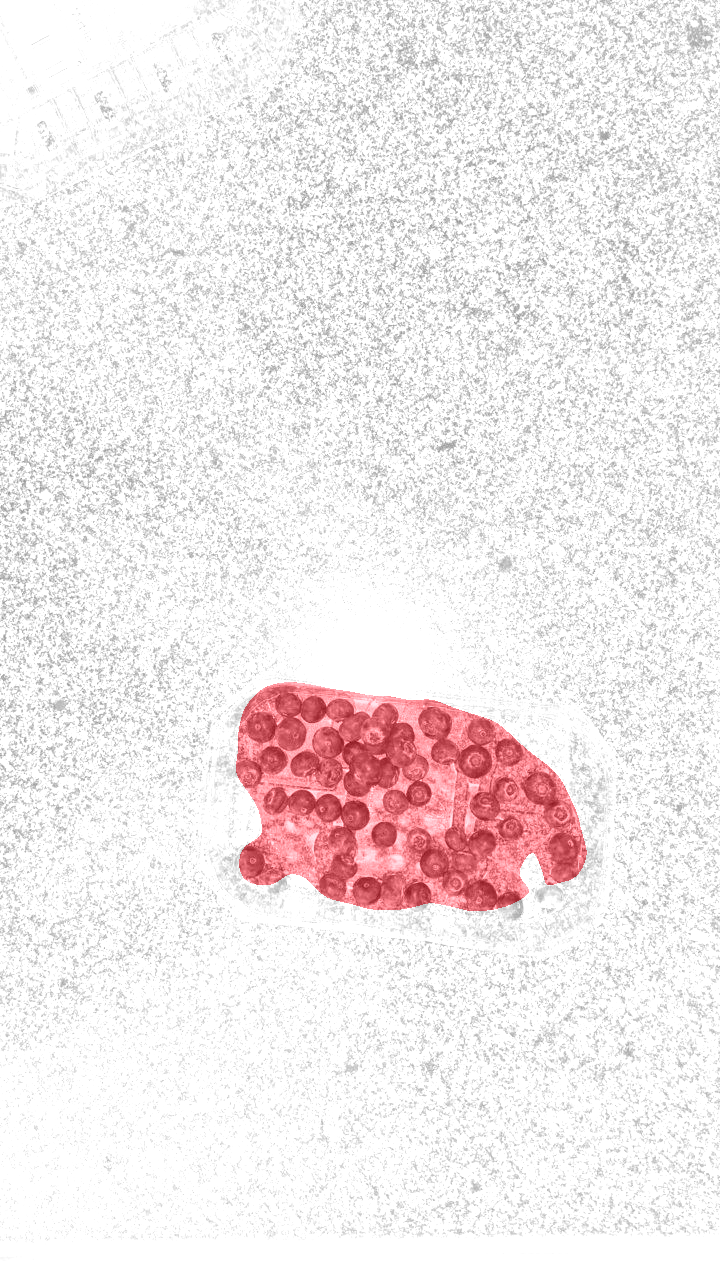

In [ ]:
img

In [ ]:
clip_df

,clip,text,version,description,category,energy,protein,carb,fat,score,classes,area
id,,,,,,,,,,,,
1101616,"[0.01829599, 0.00657517, 0.048387296, 0.048359...","the photo of ""Quinoa, NS as to fat"" dish, whi...",1,"Quinoa, NS as to fat","Pasta, noodles, cooked grains",140.0,4.18,20.22,4.75,0.321500,10,34472
1099079,"[0.015603526, 0.009637079, -0.0050173826, 0.01...","the photo of ""Octopus, cooked, NS as to cooki...",1,"Octopus, cooked, NS as to cooking method",Shellfish,222.0,16.30,12.16,11.63,0.307631,94,32233
1099087,"[0.009943965, 0.031631686, -0.013362202, 0.021...","the photo of ""Squid, raw"" dish, which is made...",1,"Squid, raw",Shellfish,92.0,15.58,3.08,1.38,0.285925,95,27582
1099079,"[0.015603526, 0.009637079, -0.0050173826, 0.01...","the photo of ""Octopus, cooked, NS as to cooki...",1,"Octopus, cooked, NS as to cooking method",Shellfish,222.0,16.30,12.16,11.63,0.305746,50,24685
1101721,"[0.0044894502, 0.029371755, 0.036032338, 0.053...","the photo of ""Cereal (Post Great Grains, Cran...",1,"Cereal (Post Great Grains, Cranberry Almond Cr...","Ready-to-eat cereal, higher sugar (>21.2g/100g)",384.0,8.90,76.60,5.90,0.324428,71,10729
1101245,"[-0.016911855, 0.042472962, 0.0123993335, 0.03...","the photo of ""Cereal or granola bar, nonfat"" ...",1,"Cereal or granola bar, nonfat",Cereal bars,342.0,5.90,77.60,0.90,0.319469,104,7416
1098489,"[-0.028362885, 0.012073749, 0.02486184, 0.0159...","the photo of ""Chicken drumstick, NS as to coo...",1,"Chicken drumstick, NS as to cooking method, sk...","Chicken, whole pieces",206.0,25.65,0.12,11.46,0.250507,62,3709
1101814,"[-0.009622666, 0.026179757, 0.031976935, 0.058...","the photo of ""Cereal (Post Golden Crisp)"" dis...",1,Cereal (Post Golden Crisp),"Ready-to-eat cereal, higher sugar (>21.2g/100g)",380.0,5.50,90.10,1.70,0.239933,36,1980
1102471,"[-0.012423304, 0.020928817, 0.022754453, 0.044...","the photo of ""Flavored rice and pasta mixture...",1,Flavored rice and pasta mixture,Rice mixed dishes,118.0,2.68,19.11,3.49,0.342964,67,1299


In [ ]:
dish = clip_df.reset_index()[['id','score','area']]
dish['photo_id']         = photo['file_id']
dish['photo_message_id'] = message['message_id']
#sender = message['from'].to_python()
dish['user_id'] = sender['id']
dish['ml_version'] = 0.4 
dish['timestamp']=pd.Timestamp.utcnow()
dish = dish.rename(columns = {"id":'food_id'})

output = '; '.join(clip_df['description'].tolist())

NameError: name 'photo' is not defined

In [ ]:
stats

,0
energy,301.497162
protein,16.176838
carb,25.665462
fat,15.919412
size,153742.000000


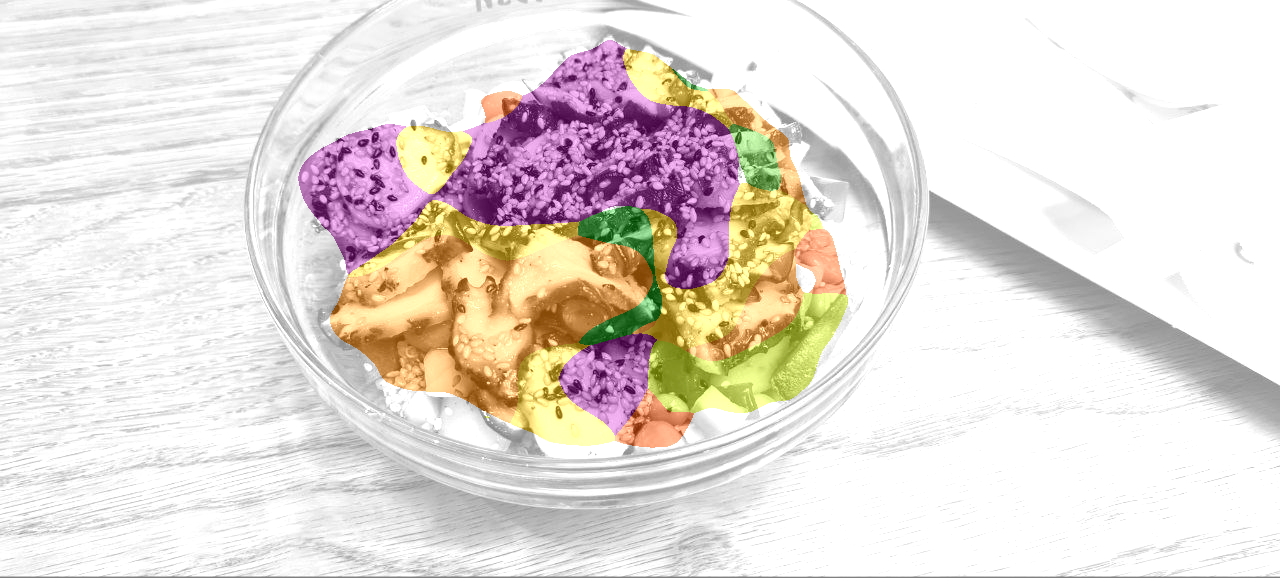

In [ ]:
img

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f search search(segment_model,path, prompt_factor=0.1,min_score=0.22,exand_times =2)

/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


Timer unit: 1e-06 s

Total time: 1.37691 s
File: /tmp/ipykernel_396248/3771660930.py
Function: search at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def search(segment_model,path=None, prompt_factor=0.5,min_score=0.22,exand_times =2):
     2         1        587.0    587.0      0.0      img = get_image(path=path)
     3         1      12540.0  12540.0      0.9      img,adj = crop_image_to_square(img,True)
     4         1          2.0      2.0      0.0      x_adj,y_adj,size = adj
     5                                           
     6         1          8.0      8.0      0.0      photo_id = url if url else path.name
     7         1          2.0      2.0      0.0      photo_id = photo_id.split('/')[-1]
     8                                           
     9         1       1447.0   1447.0      0.1      i = np.asarray(img, dtype="uint8")
    10         1         52.0     52.0      0.0      i = np.flip(i,2)
   

In [ ]:
!nbdev_export

In [ ]:
!which pip

/home/dima/anaconda3/bin/pip
